# This notebook contains experiments on the LEADER data

In [2]:
from leader_data import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from frengression import *
device = torch.device('cpu')


import numpy as np
import pickle
import os
from tqdm import tqdm
import torch.nn as nn
from copy import deepcopy

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd

np.random.seed(42)


## Static covariates

In [3]:
df_bsl=generate_bsl()

In [4]:
df_bsl.head()

,USUBJID,ARM,SEX_F,RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE,RACE_ASIAN,RACE_BLACK.OR.AFRICAN.AMERICAN,RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER,RACE_OTHER,SMOKER_CURRENT.SMOKER,SMOKER_NEVER.SMOKED,...,KIDFL,AGE,DIABDUR,BMIBL,HBA1CBL,HDL1BL,LDL1BL,CHOL1BL,TRIG1BL,CREATBL
1,EX2211-3748/5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,62.0,3.5,32.7,9.5,1.17,2.80,4.84,1.90,55.0
2,EX2211-3748/9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,56.0,3.2,26.9,6.8,0.87,1.82,3.27,1.28,77.0
3,EX2211-3748/16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,60.0,13.9,31.5,11.9,0.85,2.42,4.17,1.97,70.0
4,EX2211-3748/20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,59.0,2.1,43.9,9.6,1.14,2.49,4.84,2.64,55.0
5,EX2211-3748/62,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,71.0,11.5,28.4,8.5,1.06,2.02,4.53,3.14,81.0


In [5]:
df_bsl.columns

Index(['USUBJID', 'ARM', 'SEX_F', 'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
       'RACE_ASIAN', 'RACE_BLACK.OR.AFRICAN.AMERICAN',
       'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER', 'RACE_OTHER',
       'SMOKER_CURRENT.SMOKER', 'SMOKER_NEVER.SMOKED', 'MIFL', 'STROKEFL',
       'STENFL', 'NEPSCRFL', 'KIDFL', 'AGE', 'DIABDUR', 'BMIBL', 'HBA1CBL',
       'HDL1BL', 'LDL1BL', 'CHOL1BL', 'TRIG1BL', 'CREATBL'],
      dtype='object')

In [6]:
cols_cov = ['SEX_F', 'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
       'RACE_ASIAN', 'RACE_BLACK.OR.AFRICAN.AMERICAN',
       'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER', 'RACE_OTHER',
       'SMOKER_CURRENT.SMOKER', 'SMOKER_NEVER.SMOKED', 'MIFL', 'STROKEFL',
       'STENFL', 'NEPSCRFL', 'KIDFL', 'AGE', 'DIABDUR', 'BMIBL', 'HBA1CBL',
       'HDL1BL', 'LDL1BL', 'CHOL1BL', 'TRIG1BL', 'CREATBL']

In [7]:
df_bsl.dropna(inplace=True)

In [ ]:
p = 22
binary_intervention = True
z_tr = torch.tensor(df_bsl[cols_cov].values, dtype=torch.float32)
x_tr = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)
# placeholder
y_tr = torch.tensor(df_bsl['ARM'].values, dtype=torch.float32).view(-1, 1)

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=13)
model.train_xz(x_tr, z_tr, num_iters=12000, lr=5e-3, print_every_iter=1000)

Epoch 1: loss 116.5832, loss1 116.7301, loss2 0.2937
Epoch 1000: loss 20.8962, loss1 40.1782, loss2 38.5639
Epoch 2000: loss 20.8283, loss1 40.6378, loss2 39.6191
Epoch 3000: loss 20.4887, loss1 40.4711, loss2 39.9649
Epoch 4000: loss 20.8869, loss1 40.8021, loss2 39.8305
Epoch 5000: loss 20.8809, loss1 40.8084, loss2 39.8551
Epoch 6000: loss 20.7254, loss1 40.8271, loss2 40.2034
Epoch 7000: loss 20.7336, loss1 41.1133, loss2 40.7594
Epoch 8000: loss 20.8818, loss1 41.9247, loss2 42.0859
Epoch 9000: loss 20.9951, loss1 41.3635, loss2 40.7367
Epoch 10000: loss 20.6926, loss1 40.9919, loss2 40.5987
Epoch 11000: loss 20.7148, loss1 40.6550, loss2 39.8804
Epoch 12000: loss 20.8291, loss1 40.8262, loss2 39.9941


In [ ]:
x,z=model.sample_xz(sample_size=df_bsl.shape[0])
xz=torch.cat([x,z],dim=1)
original_df = deepcopy(df_bsl)
simulated_df = pd.DataFrame(xz.numpy())
simulated_df.columns = original_df.columns[1:]
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

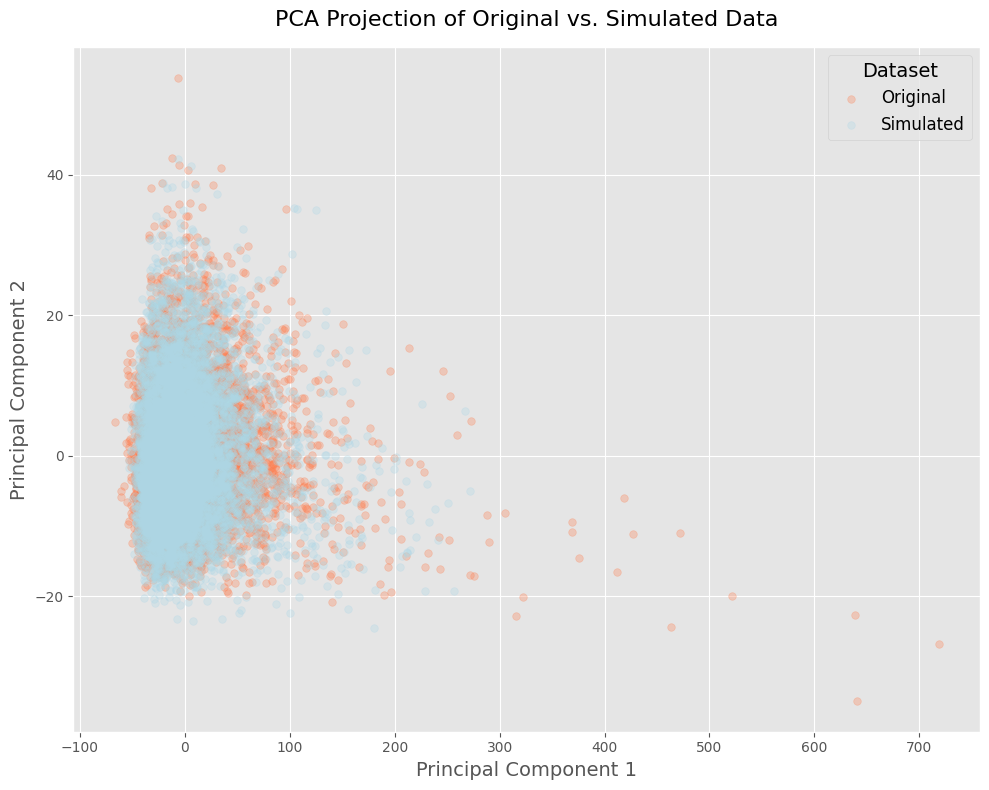

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Prepare the Data ---
# Label each DataFrame
original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

# Combine the two datasets
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

# --- Plotting ---
# Choose a clean style: try 'seaborn' if available, else use 'ggplot'
style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))

# Define colors: 'coral' for Original and 'lightblue' for Simulated.
colors = {'Original': 'coral', 'Simulated': 'lightblue'}

# Plot each dataset without edge colors
for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

# Set titles and labels with a modern font size
ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

# Customize the legend
ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()


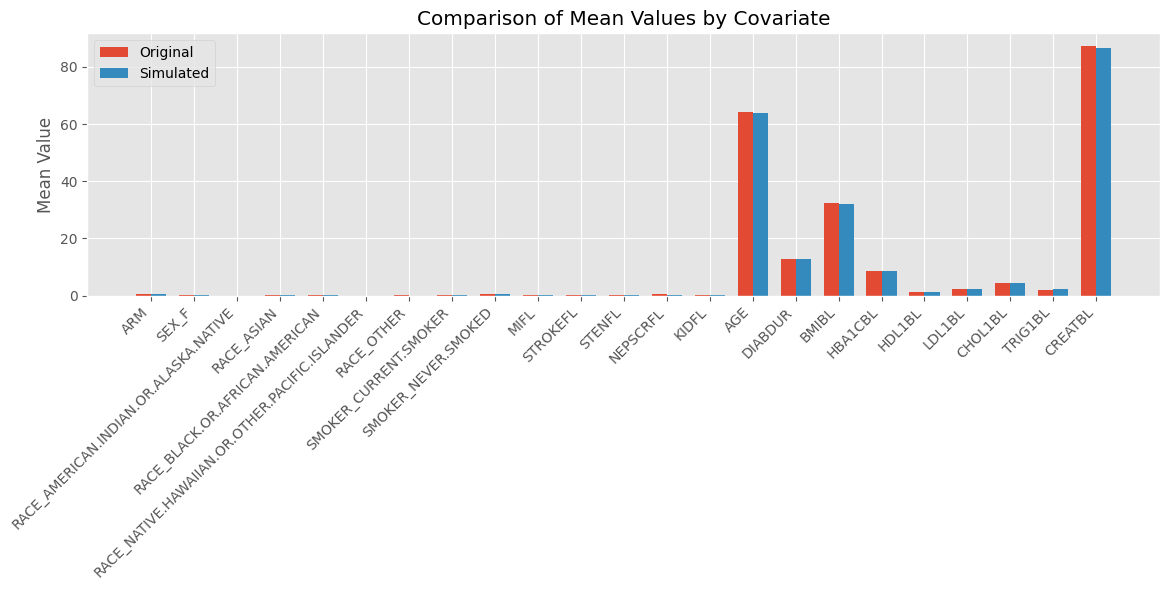

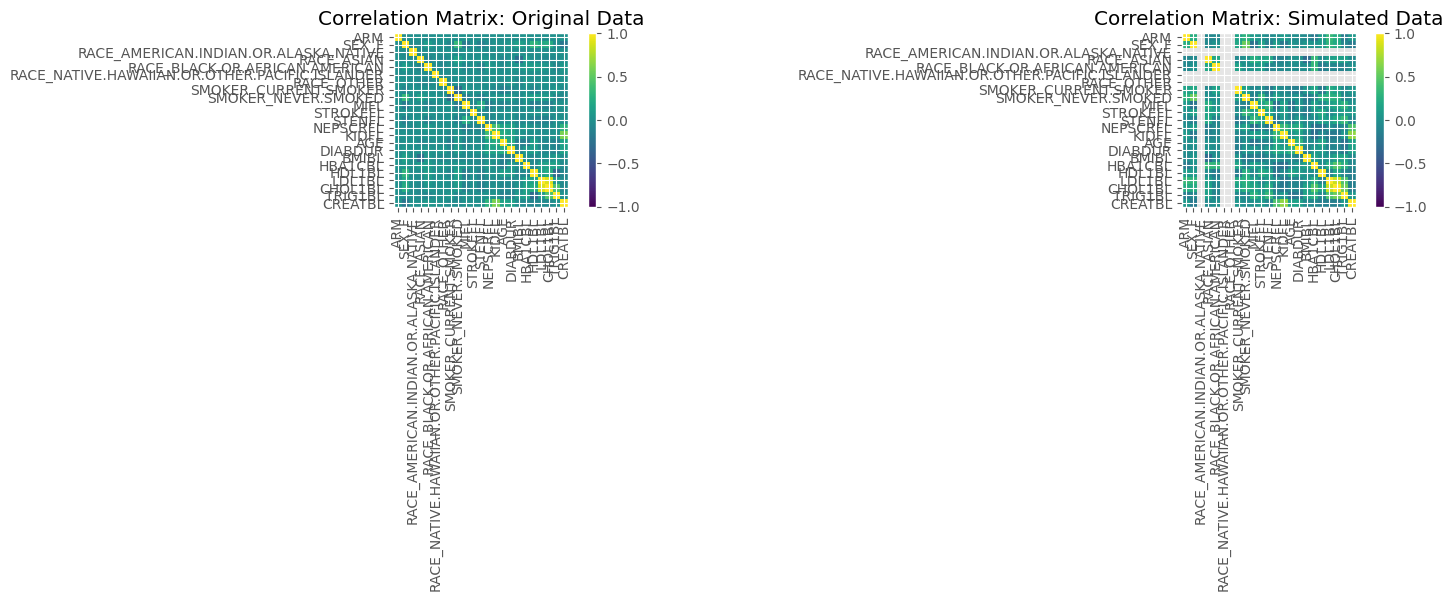

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.54      0.56      2749
           1       0.58      0.63      0.61      2749

    accuracy                           0.59      5498
   macro avg       0.59      0.59      0.58      5498
weighted avg       0.59      0.59      0.58      5498

Accuracy: 0.59
ROC AUC: 0.61


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

plt.style.use('ggplot')  # Use a beautiful built-in style
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

ax.set_xticks(x)
ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
ax.set_ylabel('Mean Value')
ax.set_title('Comparison of Mean Values by Covariate')
ax.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# 2. Dependency Structure Comparison
# ---------------------------
# Compute correlation matrices
corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

# ---------------------------
# 3. Classifier to Distinguish Datasets
# ---------------------------
# For the classifier test, we create a new label column: 0 for original, 1 for simulated.
# First, copy the DataFrames to avoid modifying the originals.
orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


## Reduce number of binary covariates by selecting race == white

In [ ]:
cols = [
    'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN',
]

df_bsl_filtered = df_bsl[df_bsl[cols].eq(0).all(axis=1)]
df_bsl_filtered.drop(columns=cols,inplace=True)


/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_4928/119980743.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bsl_filtered.drop(columns=cols,inplace=True)


In [ ]:
cols_cov = ['SEX_F', 'SMOKER_CURRENT.SMOKER',
       'SMOKER_NEVER.SMOKED', 'MIFL', 'STROKEFL', 'STENFL', 'NEPSCRFL',
       'KIDFL', 'AGE', 'DIABDUR', 'BMIBL', 'HBA1CBL', 'HDL1BL', 'LDL1BL',
       'CHOL1BL', 'TRIG1BL', 'CREATBL']
p = len(cols_cov)
print(f'number of covariates: {p}')
binary_intervention = True
z_tr = torch.tensor(df_bsl_filtered[cols_cov].values, dtype=torch.float32)
x_tr = torch.tensor(df_bsl_filtered['ARM'].values, dtype=torch.int32).view(-1, 1)
# placeholder
y_tr = torch.tensor(df_bsl_filtered['ARM'].values, dtype=torch.float32).view(-1, 1)

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=8)
model.train_xz(x_tr, z_tr, num_iters=12000, lr=5e-3, print_every_iter=1000)

In [ ]:
model.train_xz(x_tr, z_tr, num_iters=4000, lr=1e-3, print_every_iter=1000)

Epoch 1: loss 19.9547, loss1 38.9502, loss2 37.9911
Epoch 1000: loss 19.7456, loss1 39.5814, loss2 39.6716
Epoch 2000: loss 20.0197, loss1 39.6088, loss2 39.1782
Epoch 3000: loss 19.5949, loss1 39.3926, loss2 39.5954
Epoch 4000: loss 20.1564, loss1 39.5900, loss2 38.8673


In [ ]:
x,z=model.sample_xz(sample_size=df_bsl_filtered.shape[0])
# x,z=model.sample_xz(sample_size=5000)
xz=torch.cat([x,z],dim=1)
original_df = deepcopy(df_bsl_filtered)
simulated_df = pd.DataFrame(xz.numpy())
simulated_df.columns = original_df.columns[1:]
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

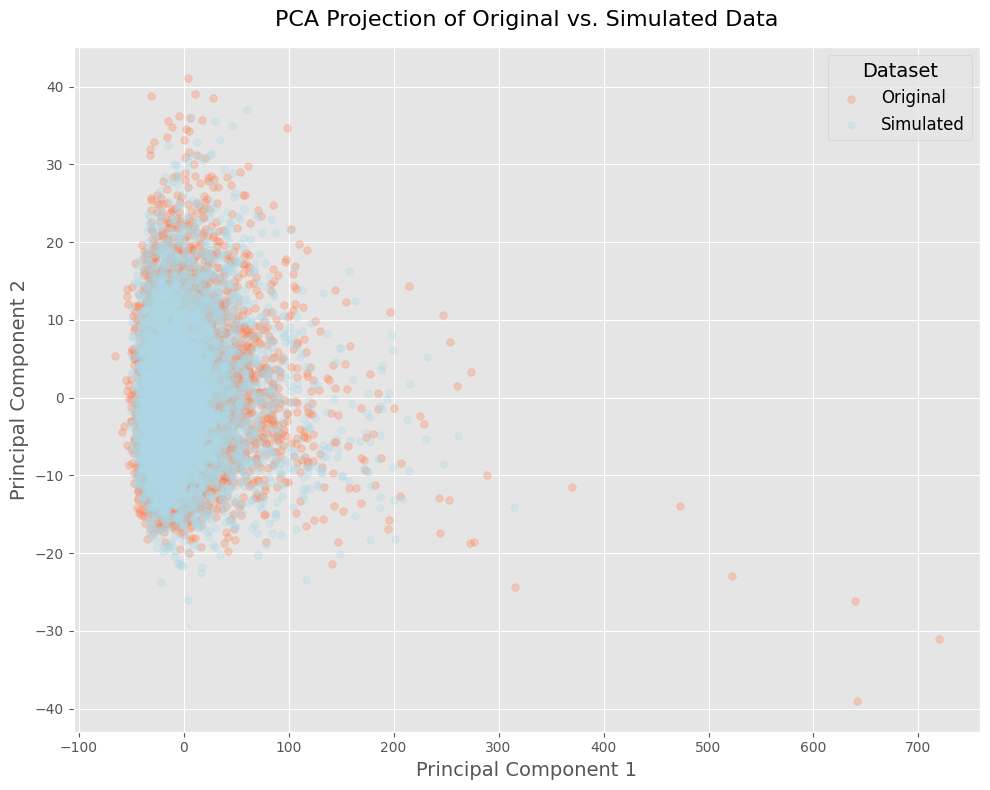

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Prepare the Data ---
# Label each DataFrame
original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

# Combine the two datasets
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

# --- Plotting ---
# Choose a clean style: try 'seaborn' if available, else use 'ggplot'
style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))

# Define colors: 'coral' for Original and 'lightblue' for Simulated.
colors = {'Original': 'coral', 'Simulated': 'lightblue'}

# Plot each dataset without edge colors
for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

# Set titles and labels with a modern font size
ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

# Customize the legend
ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()


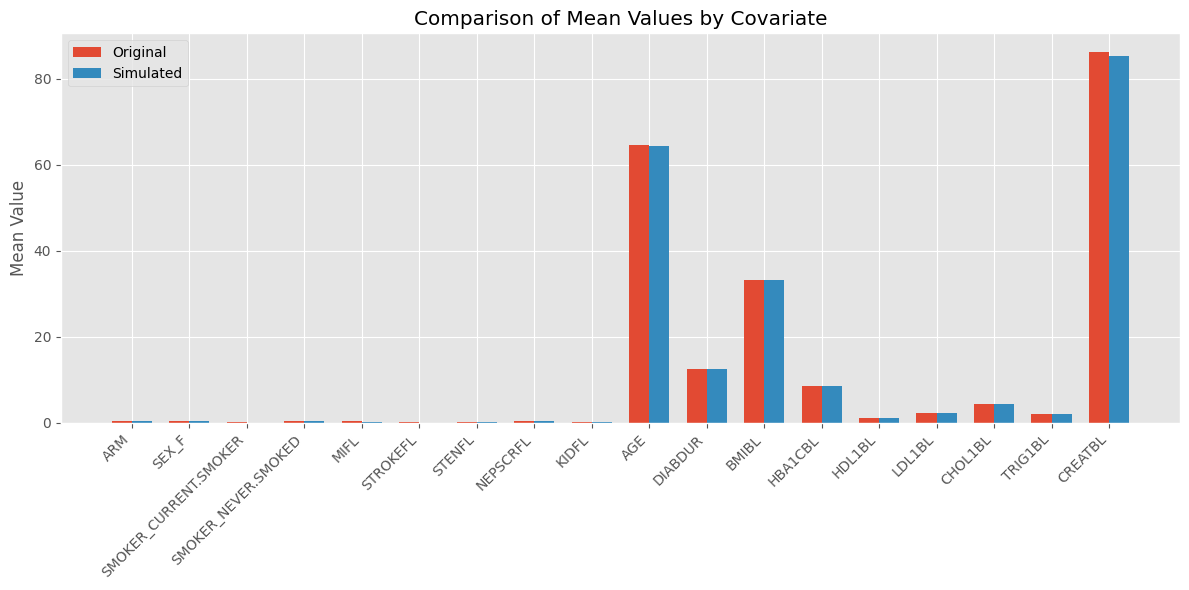

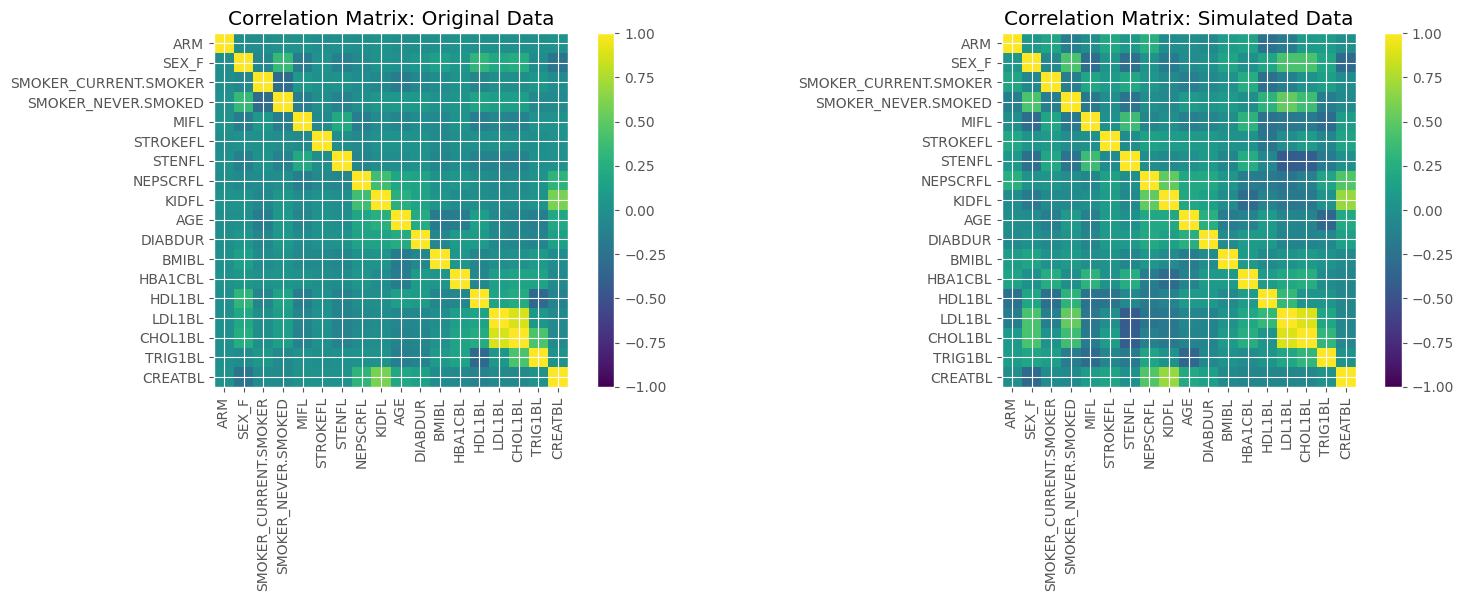

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61      2132
           1       0.62      0.71      0.66      2132

    accuracy                           0.64      4264
   macro avg       0.64      0.64      0.63      4264
weighted avg       0.64      0.64      0.63      4264

Accuracy: 0.64
ROC AUC: 0.69


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

plt.style.use('ggplot')  # Use a beautiful built-in style
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

ax.set_xticks(x)
ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
ax.set_ylabel('Mean Value')
ax.set_title('Comparison of Mean Values by Covariate')
ax.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# 2. Dependency Structure Comparison
# ---------------------------
# Compute correlation matrices
corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

# ---------------------------
# 3. Classifier to Distinguish Datasets
# ---------------------------
# For the classifier test, we create a new label column: 0 for original, 1 for simulated.
# First, copy the DataFrames to avoid modifying the originals.
orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


# Longitudinal

In [13]:
df_outcome=generate_outcome()
df_outcome

df_Y = df_outcome[['USUBJID'] + [f'Y{i}' for i in range(1, 11)]]
df_I = df_outcome[['USUBJID'] + [f'I{i}' for i in range(1, 11)]]
df_D = df_outcome[['USUBJID'] + [f'D{i}' for i in range(1, 11)]]

df_Y


,USUBJID,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
1,EX2211-3748/5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EX2211-3748/9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EX2211-3748/16,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,EX2211-3748/62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9337,EX2211-3748/99921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9338,EX2211-3748/99929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9339,EX2211-3748/99971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_egfr, df_hba1c, df_bmi = generate_longi_cov()

In [15]:
df_hba1c

,USUBJID,0,12,18,24,3,30,36,42,48,54,6,60,1,61
1,EX2211-3748/10012,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,7.1,NaN,NaN
2,EX2211-3748/10023,7.6,6.0,6.3,6.0,6.3,6.1,6.4,6.8,6.5,6.5,6.3,7.3,NaN,NaN
3,EX2211-3748/10028,9.9,9.5,7.9,9.6,8.4,9.2,9.9,9.6,9.6,9.6,8.6,9.6,NaN,NaN
4,EX2211-3748/10034,9.6,9.6,9.5,9.3,9.6,7.0,6.0,6.0,6.0,6.0,10.9,6.3,NaN,NaN
5,EX2211-3748/10050,7.5,7.8,8.9,8.7,8.0,8.5,8.1,8.1,8.1,8.1,6.3,9.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,7.1,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN
9337,EX2211-3748/99921,8.6,6.5,6.6,6.6,6.0,6.5,7.0,7.0,7.0,7.0,6.1,6.3,NaN,NaN
9338,EX2211-3748/99929,7.3,7.0,7.0,7.0,6.9,7.0,7.0,7.0,7.0,7.0,6.9,7.0,NaN,NaN
9339,EX2211-3748/99971,10.5,8.3,10.0,11.1,9.8,10.0,9.4,9.7,9.7,9.7,9.7,10.7,8.9,NaN


In [16]:
df_bmi

,USUBJID,0,12,24,36,48,6,60
1,EX2211-3748/10012,31.6,31.6,31.6,31.6,31.6,31.6,31.6
2,EX2211-3748/10023,39.0,37.3,37.3,38.2,39.5,38.5,39.9
3,EX2211-3748/10028,30.8,30.7,30.4,29.3,29.3,30.6,30.1
4,EX2211-3748/10034,41.4,42.6,41.7,30.4,30.4,41.9,29.5
5,EX2211-3748/10050,50.8,48.8,45.8,45.2,45.2,45.1,44.7
...,...,...,...,...,...,...,...,...
9327,EX2211-3748/99915,37.5,37.5,37.5,37.5,37.5,37.5,37.5
9328,EX2211-3748/99921,33.7,31.4,33.3,33.4,33.4,31.1,33.1
9329,EX2211-3748/99929,27.0,27.8,27.8,27.8,27.8,28.4,27.8
9330,EX2211-3748/99971,28.0,31.3,29.9,29.7,29.7,29.7,29.6


In [17]:
df_egfr

,USUBJID,0,12,24,36,48,6,60,61,30,42,1,18,3,54
1,EX2211-3748/10012,96.7,96.7,96.7,96.7,96.7,96.7,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EX2211-3748/10023,84.3,89.5,91.2,86.8,84.3,91.2,84.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EX2211-3748/10028,84.4,77.1,70.0,88.5,88.5,78.3,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX2211-3748/10034,75.5,91.0,83.3,78.0,78.0,79.2,92.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,EX2211-3748/10050,75.7,90.0,59.0,42.3,42.3,100.6,65.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,EX2211-3748/99915,79.8,79.8,79.8,79.8,79.8,79.8,79.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9337,EX2211-3748/99921,93.1,94.2,93.6,81.4,81.4,96.9,77.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9338,EX2211-3748/99929,105.1,107.0,107.0,107.0,107.0,93.6,107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9339,EX2211-3748/99971,103.4,90.7,91.2,95.0,95.0,85.2,90.7,NaN,NaN,NaN,95.6,NaN,NaN,NaN


The longitudinal features are processed with these rules:
1. As hba1c has been measured several times, we use it as the benchmark for marking the records. However, we still discard month = 1 and month = 61 as there are not that many
2. Since egfr and bmi are measured less frequently, we impute the missing values using the observations in the previous visit time.
3. The simulated data will be evaluated by masking up intervals that the egfr and bmi are not recorded.


In [18]:
import pandas as pd
import numpy as np
import torch
from copy import deepcopy

# ------------------------- Load Your Data -------------------------
df_z1 = deepcopy(df_hba1c)   # longitudinal covariate z1
df_z2 = deepcopy(df_egfr)    # longitudinal covariate z2
df_z3 = deepcopy(df_bmi)     # longitudinal covariate z3
df_bsl = deepcopy(df_bsl)    # baseline covariates
df_Y = deepcopy(df_Y)        # outcome
df_bsl.dropna(inplace=True)
# --------------------- Process df_Y (Outcome) ---------------------
# --------------------- Process df_Y (Outcome) ---------------------
if 'Y0' not in df_Y.columns:
    df_Y.insert(1, 'Y0', 0.0)
df_Y = df_Y[['USUBJID'] + [f'Y{i}' for i in range(0, 11)]]  # Y0 to Y10

# ----------------- Time Points You Care About ---------------------
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

# ----------------- Longitudinal Processing Function -----------------
def process_longitudinal(df, time_points):
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points if str(tp) in df.columns]].copy()
    for tp in time_points:
        col = str(tp)
        if col not in df.columns:
            df.loc[:, col] = np.nan
    df = df.loc[:, ['USUBJID'] + [str(tp) for tp in time_points]]

    df['na_count'] = df.isna().sum(axis=1)
    df = df.loc[df['na_count'] <= 5].drop(columns='na_count').reset_index(drop=True)

    for idx in range(len(df)):
        for t_idx, t in enumerate(time_points):
            col = str(t)
            if pd.isna(df.loc[idx, col]):
                for prev_t in reversed(time_points[:t_idx]):
                    prev_col = str(prev_t)
                    if not pd.isna(df.loc[idx, prev_col]):
                        df.loc[idx, col] = df.loc[idx, prev_col]
                        break

    return df

# ------------- Process and Clean z1, z2, z3 ----------------
df_z1_clean = process_longitudinal(df_z1, time_points)
df_z2_clean = process_longitudinal(df_z2, time_points)
df_z3_clean = process_longitudinal(df_z3, time_points)


df_z1_clean = df_z1_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z2_clean = df_z2_clean.dropna(axis=0, how='any').reset_index(drop=True)
df_z3_clean = df_z3_clean.dropna(axis=0, how='any').reset_index(drop=True)



# # ----------- Special fill for z3 missing months ----------------
# for target, source in [(18,12), (42,36), (54,48)]:
#     target, source = str(target), str(source)
#     if target not in df_z3_clean.columns:
#         df_z3_clean[target] = np.nan
#     df_z3_clean.loc[:, target] = df_z3_clean.loc[:, target].fillna(df_z3_clean.loc[:, source])

# df_z3_clean = process_longitudinal(df_z3_clean, time_points)

# ------------ Align All by Intersection of USUBJID -------------
common_ids = set(df_Y['USUBJID']) & set(df_z1_clean['USUBJID']) & set(df_z2_clean['USUBJID']) & set(df_z3_clean['USUBJID']) & set(df_bsl['USUBJID'])
df_Y = df_Y[df_Y['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z1_clean = df_z1_clean[df_z1_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z2_clean = df_z2_clean[df_z2_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_z3_clean = df_z3_clean[df_z3_clean['USUBJID'].isin(common_ids)].reset_index(drop=True)
df_bsl = df_bsl[df_bsl['USUBJID'].isin(common_ids)].reset_index(drop=True)

# ------------ Sort all by USUBJID to align ----------------------
df_Y.sort_values(by='USUBJID', inplace=True)
df_z1_clean.sort_values(by='USUBJID', inplace=True)
df_z2_clean.sort_values(by='USUBJID', inplace=True)
df_z3_clean.sort_values(by='USUBJID', inplace=True)
df_bsl.sort_values(by='USUBJID', inplace=True)

# ----------------- Build the Z torch tensor (longitudinal) ----------------------
Z_list = []
for idx in range(len(df_z1_clean)):
    z1_vals = df_z1_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z2_vals = df_z2_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    z3_vals = df_z3_clean.iloc[idx][[str(tp) for tp in time_points]].astype(float).values
    Z_subj = np.column_stack([z1_vals, z2_vals, z3_vals]).reshape(-1)
    # Z_subj = np.column_stack([z1_vals]).reshape(-1)
    Z_list.append(Z_subj.astype(np.float32))

z_tensor = torch.tensor(np.vstack(Z_list), dtype=torch.float32)  # Shape (n_subjects, 33)

# ----------------- Build the X tensor (ARM repeated over time) -------------------
# Pull ARM values
arm_values = df_bsl['ARM'].astype(float).values  # shape (n_subjects,)
x_tensor = torch.tensor(np.repeat(arm_values[:, np.newaxis], len(time_points), axis=1), dtype=torch.int32)
# Shape: (n_subjects, 11) => ARM repeated for 11 time steps

# ------------------ Build the y torch tensor ----------------------
y_cols = [f'Y{i}' for i in range(0, 11)]
y_np = df_Y[y_cols].astype(float).values  # Ensure it's float, so NaN is preserved
y_tensor = torch.tensor(y_np, dtype=torch.int32)

# ----------------- Build the S tensor (baseline features) -------------------
# Optional: Drop USUBJID since it's only for alignment
df_bsl_features = df_bsl.drop(columns=['USUBJID','ARM',  'RACE_AMERICAN.INDIAN.OR.ALASKA.NATIVE',
    'RACE_NATIVE.HAWAIIAN.OR.OTHER.PACIFIC.ISLANDER',
    'RACE_OTHER',
    'RACE_ASIAN',
    'RACE_BLACK.OR.AFRICAN.AMERICAN'])
# df_bsl_features = df_bsl['AGE']
# # Optional safety: double check it's numeric for torch
df_bsl_features = df_bsl_features.astype(float)
x_bsl_tensor = torch.tensor(df_bsl['ARM'].values, dtype=torch.int32).view(-1, 1)

# Create the s_tensor
s_tensor = torch.tensor(df_bsl_features.values, dtype=torch.float32)

# ----------------- Check shape -------------------
print(f"s_tensor shape: {s_tensor.shape}")  # (n_subjects, num_baseline_features)


# ------------------ Print shapes to verify -----------------------
print(f"z_tensor shape: {z_tensor.shape}")  # (n_subjects, 33)
print(f"x_tensor shape (ARM): {x_tensor.shape}")  # (n_subjects, 11)
print(f"y_tensor shape: {y_tensor.shape}")  # (n_subjects, 11)

# Optional: Sanity check USUBJID order alignment
print(np.all(df_Y['USUBJID'].values == df_z1_clean['USUBJID'].values) and np.all(df_Y['USUBJID'].values == df_bsl['USUBJID'].values))
print(torch.isnan(y_tensor).any())  # Should return True if any NaN exists
assert not df_z1_clean.isnull().values.any(), "NaN detected in z1"
assert not df_z2_clean.isnull().values.any(), "NaN detected in z2"
assert not df_z3_clean.isnull().values.any(), "NaN detected in z3"


s_tensor shape: torch.Size([9161, 17])
z_tensor shape: torch.Size([9161, 33])
x_tensor shape (ARM): torch.Size([9161, 11])
y_tensor shape: torch.Size([9161, 11])
True
tensor(False)


## train baseline model for simulating s

In [ ]:
p = s_tensor.shape[1]
print(f'number of covariates: {p}')
binary_intervention = True


model_bsl = Frengression(x_bsl_tensor.shape[1], y_tensor.shape[1], s_tensor.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention, z_binary_dims=8)
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=8000, lr=5e-3, print_every_iter=1000)

number of covariates: 22
Epoch 1: loss 116.3275, loss1 116.4765, loss2 0.2981
Epoch 1000: loss 20.7312, loss1 40.0913, loss2 38.7202
Epoch 2000: loss 20.4814, loss1 39.8885, loss2 38.8142
Epoch 3000: loss 20.8005, loss1 40.3295, loss2 39.0580
Epoch 4000: loss 20.7771, loss1 40.3871, loss2 39.2201
Epoch 5000: loss 20.4780, loss1 40.5428, loss2 40.1297
Epoch 6000: loss 20.8763, loss1 40.9330, loss2 40.1135
Epoch 7000: loss 20.9770, loss1 40.9475, loss2 39.9410
Epoch 8000: loss 20.6514, loss1 40.4377, loss2 39.5726


In [33]:
s_tensor.shape[1]

17

In [32]:
model_bsl.train_xz(x_bsl_tensor, s_tensor, num_iters=8000, lr=5e-3, print_every_iter=1000)

Epoch 1: loss 20.9174, loss1 40.6118, loss2 39.3889
Epoch 1000: loss 20.5479, loss1 40.6895, loss2 40.2833
Epoch 2000: loss 20.7887, loss1 40.6411, loss2 39.7050
Epoch 3000: loss 20.7731, loss1 40.9558, loss2 40.3654
Epoch 4000: loss 20.5199, loss1 40.8157, loss2 40.5918
Epoch 5000: loss 20.5811, loss1 40.8828, loss2 40.6033
Epoch 6000: loss 20.8606, loss1 40.5116, loss2 39.3020
Epoch 7000: loss 20.6590, loss1 40.5618, loss2 39.8055
Epoch 8000: loss 20.7138, loss1 40.6087, loss2 39.7900


In [63]:
model = FrengressionSurv(x_dim=1, y_dim=1, z_dim=3, T=11, s_dim = 17, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True, y_binary=True)
# model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=3000, lr=1e-4, print_every_iter=200)

In [64]:
model.train_y(s=s_tensor,x=x_tensor,z=z_tensor,y=y_tensor,num_iters=10000, lr=1e-3, print_every_iter=100,reg_lambda=5)

Epoch 1: loss 7366.6875,	loss_y 1.6023, 1.6095, 0.0144,	loss_eta 12.3118, 14.2760, 3.9284, 	marginal_loss 1470.5547
Epoch 1: y_sample_mean 0.013515792787075043
Epoch 1: y_sample1_cat.float().mean() 0.38001570105552673
Epoch 100: loss 2.5825,	loss_y 0.2414, 0.2436, 0.0043,	loss_eta 2.3296, 4.9755, 5.2919, 	marginal_loss 0.0023
Epoch 100: y_sample_mean 0.013406635262072086
Epoch 100: y_sample1_cat.float().mean() 0.012949056923389435
Epoch 200: loss 2.5322,	loss_y 0.2312, 0.2358, 0.0091,	loss_eta 2.2937, 4.8548, 5.1222, 	marginal_loss 0.0015
Epoch 200: y_sample_mean 0.013555487617850304
Epoch 200: y_sample1_cat.float().mean() 0.013184583745896816
Epoch 300: loss 2.4949,	loss_y 0.2043, 0.2099, 0.0112,	loss_eta 2.2906, 4.8019, 5.0225, 	marginal_loss 0.0000
Epoch 300: y_sample_mean 0.013366940431296825
Epoch 300: y_sample1_cat.float().mean() 0.013342900201678276
Epoch 400: loss 2.4894,	loss_y 0.1944, 0.2007, 0.0125,	loss_eta 2.2933, 4.7812, 4.9758, 	marginal_loss 0.0003
Epoch 400: y_sample_m

In [65]:
model.train_xz(s=s_tensor, x=x_tensor, z=z_tensor, y=y_tensor, num_iters=3000, lr=1e-4, print_every_iter=200)

Epoch 1: loss 280.1913, loss1 280.3332, loss2 0.2837
Epoch 200: loss 50.1376, loss1 50.9263, loss2 1.5775
Epoch 400: loss 29.5429, loss1 31.4221, loss2 3.7584
Epoch 600: loss 22.6658, loss1 25.8060, loss2 6.2804
Epoch 800: loss 20.5497, loss1 25.1409, loss2 9.1825
Epoch 1000: loss 19.1316, loss1 25.4412, loss2 12.6192
Epoch 1200: loss 17.9700, loss1 26.0665, loss2 16.1930
Epoch 1400: loss 17.0398, loss1 26.9912, loss2 19.9028
Epoch 1600: loss 16.4496, loss1 28.0029, loss2 23.1065
Epoch 1800: loss 16.0390, loss1 28.8619, loss2 25.6457
Epoch 2000: loss 15.8148, loss1 29.3627, loss2 27.0957
Epoch 2200: loss 15.6688, loss1 29.7456, loss2 28.1537
Epoch 2400: loss 15.3690, loss1 29.8218, loss2 28.9055
Epoch 2600: loss 15.4120, loss1 29.8818, loss2 28.9398
Epoch 2800: loss 15.4147, loss1 29.8349, loss2 28.8404
Epoch 3000: loss 15.2967, loss1 29.7286, loss2 28.8637


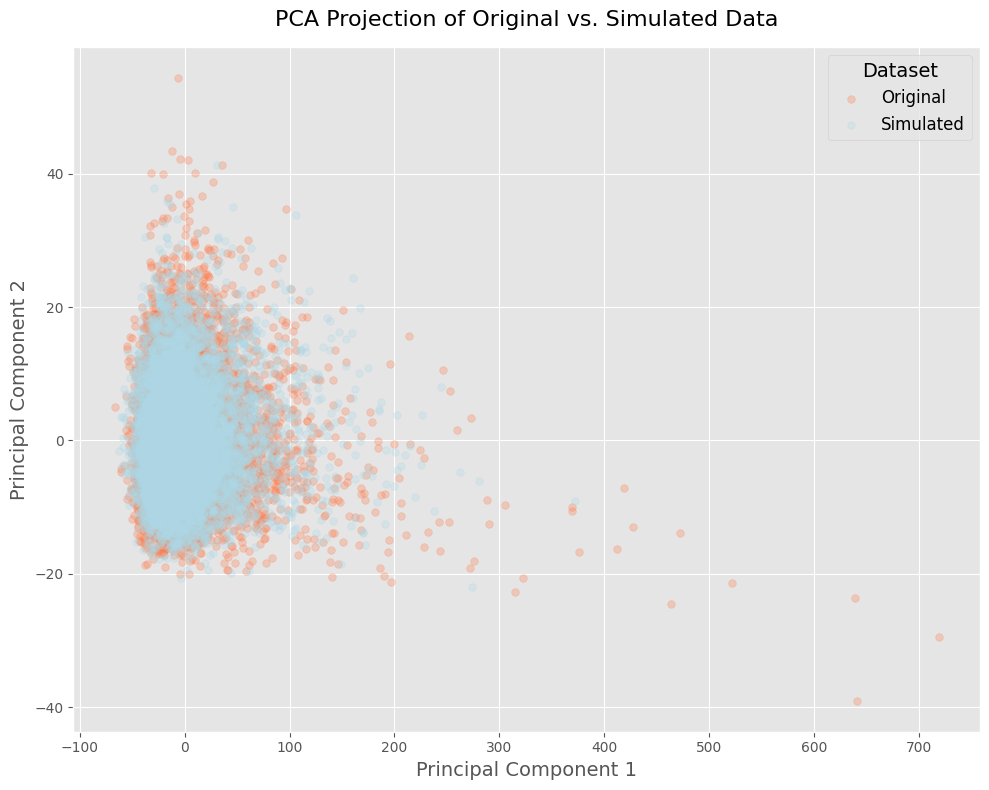

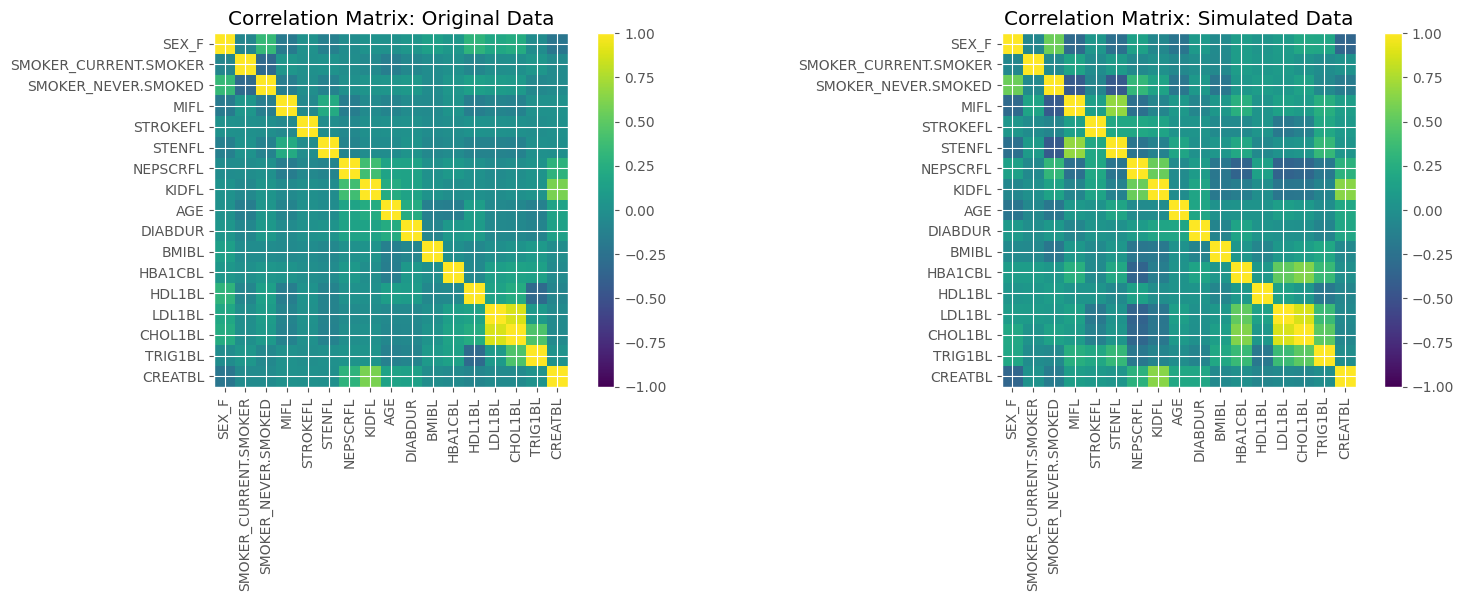

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.48      0.55      2749
           1       0.58      0.72      0.64      2748

    accuracy                           0.60      5497
   macro avg       0.61      0.60      0.60      5497
weighted avg       0.61      0.60      0.60      5497

Accuracy: 0.60
ROC AUC: 0.65


In [40]:
x,s_pred=model_bsl.sample_xz(sample_size=s_tensor.shape[0])

original_df = deepcopy(df_bsl_features)
simulated_df = pd.DataFrame(s_pred.numpy())
simulated_df.columns = original_df.columns
original_df ['source'] = 'original'
simulated_df['source'] = 'simulated'
# original_df.drop(columns={'USUBJID'},inplace=True)
combined_df = pd.concat([original_df, simulated_df], ignore_index=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

original_df['source'] = 'Original'
simulated_df['source'] = 'Simulated'

combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
features = combined_df.drop(columns='source')
labels = combined_df['source']

# --- PCA Transformation ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['source'] = labels.values

style = 'seaborn' if 'seaborn' in plt.style.available else 'ggplot'
plt.style.use(style)

fig, ax = plt.subplots(figsize=(10, 8))


colors = {'Original': 'coral', 'Simulated': 'lightblue'}

for group in pca_df['source'].unique():
    group_data = pca_df[pca_df['source'] == group]
    ax.scatter(group_data['PC1'], group_data['PC2'],
               s=30, alpha=0.3, label=group, color=colors[group])

ax.set_title('PCA Projection of Original vs. Simulated Data', fontsize=16, pad=15)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)

ax.legend(title='Dataset', fontsize=12, title_fontsize=14, loc='best')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# ---------------------------
# 1. Population Summary Comparison
# ---------------------------
# Compute mean values for each covariate
original_df.drop(columns={'source'},inplace=True)
simulated_df.drop(columns={'source'},inplace=True)
mean_original = original_df.mean()
mean_simulated = simulated_df.mean()

# Create a grouped bar chart comparing means
x = np.arange(len(mean_original))  # positions for each covariate
width = 0.35  # width of the bars

# plt.style.use('ggplot')  # Use a beautiful built-in style
# fig, ax = plt.subplots(figsize=(12, 6))
# rects1 = ax.bar(x - width/2, mean_original, width, label='Original')
# rects2 = ax.bar(x + width/2, mean_simulated, width, label='Simulated')

# ax.set_xticks(x)
# ax.set_xticklabels(original_df.columns, rotation=45, ha='right')
# ax.set_ylabel('Mean Value')
# ax.set_title('Comparison of Mean Values by Covariate')
# ax.legend()
# plt.tight_layout()
# plt.show()


corr_original = original_df.corr()
corr_simulated = simulated_df.corr()

# Create two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for original data
im0 = axes[0].imshow(corr_original, cmap='viridis', vmin=-1, vmax=1)
axes[0].set_title('Correlation Matrix: Original Data')
axes[0].set_xticks(np.arange(len(corr_original.columns)))
axes[0].set_xticklabels(corr_original.columns, rotation=90)
axes[0].set_yticks(np.arange(len(corr_original.columns)))
axes[0].set_yticklabels(corr_original.columns)
plt.colorbar(im0, ax=axes[0])

# Heatmap for simulated data
im1 = axes[1].imshow(corr_simulated, cmap='viridis', vmin=-1, vmax=1)
axes[1].set_title('Correlation Matrix: Simulated Data')
axes[1].set_xticks(np.arange(len(corr_simulated.columns)))
axes[1].set_xticklabels(corr_simulated.columns, rotation=90)
axes[1].set_yticks(np.arange(len(corr_simulated.columns)))
axes[1].set_yticklabels(corr_simulated.columns)
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


orig = original_df.copy()
sim = simulated_df.copy()

orig['label'] = 0
sim['label'] = 1

# Combine the datasets
combined_df = pd.concat([orig, sim], ignore_index=True)

# Separate features and target
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Split into training and testing sets (stratified to maintain label balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a logistic regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Get predictions and predicted probabilities for AUC calculation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC: {:.2f}".format(auc))

# If the two datasets are very similar, even a strong classifier should perform poorly
# (accuracy near 50% and AUC near 0.5), indicating that it is difficult to tell them apart.


In [35]:
def missing_impute(y, x=None, z=None, x_dim=1, z_dim=1, missing_to_num=-1):
    # Create a copy of y to work on
    y_out = y.clone()  # or copy.deepcopy(y) if you prefer
    # Create an event indicator: 1 where y > 0, else 0.
    event_indicator = (y_out > 0).float()
    # Compute the cumulative sum along the time dimension.
    c = torch.cumsum(event_indicator, dim=1)
    # Shift the cumulative sum one time step to the right.
    c_shifted = torch.zeros_like(c)
    c_shifted[:, 1:] = c[:, :-1]
    # Create a mask that is True for time steps after the first event (i.e., where c_shifted > 0)
    mask = (c_shifted > 0)
    # Mask the y_out values after the first event.
    y_out[mask] = missing_to_num

    # If neither x nor z is provided, return only y_out.
    if x is None and z is None:
        return y_out

    n_obs, timesteps = y.shape  # infer number of observations and timesteps from y

    # Process x if provided.
    x_out = None
    if x is not None:
        # Reshape to (n_obs, timesteps, x_dim)
        x_out = x.clone().view(n_obs, timesteps, x_dim)
        # Expand mask to cover the x_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, x_dim)
        # Apply the mask to x_out.
        x_out[mask_expanded] = missing_to_num
        # Reshape x_out back to its original shape.
        x_out = x_out.view(n_obs, timesteps * x_dim)

    # Process z if provided.
    z_out = None
    if z is not None:

        # Reshape to (n_obs, timesteps, z_dim)
        z_out = z.clone().view(n_obs, timesteps, z_dim)
        # Expand mask to cover the z_dim features.
        mask_expanded = mask.unsqueeze(2).expand(-1, -1, z_dim)
        # Apply the mask to z_out.
        z_out[mask_expanded] = missing_to_num
        # Reshape z_out back to its original shape.
        z_out = z_out.view(n_obs, timesteps * z_dim)

    return x_out, z_out, y_out

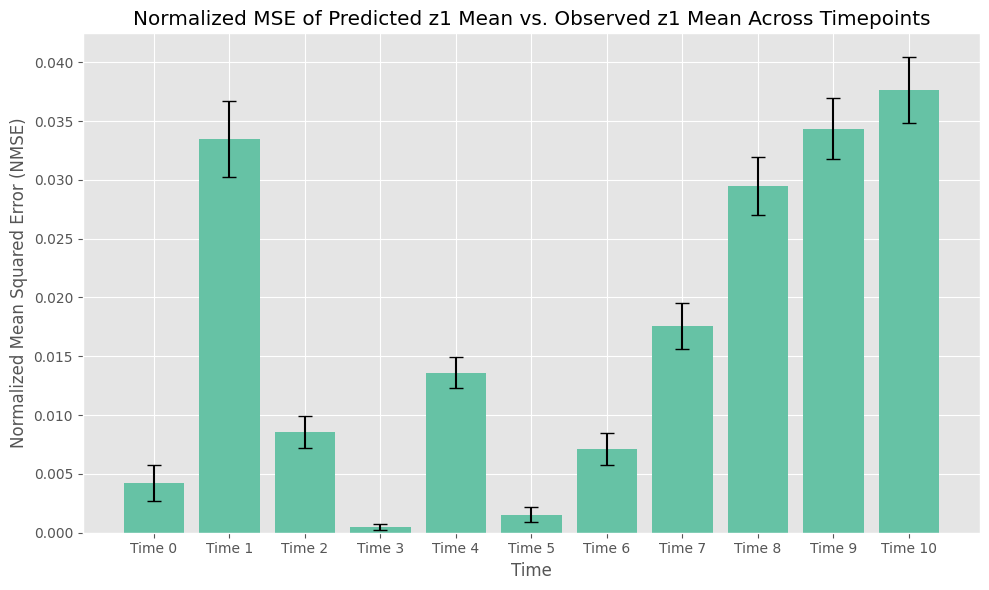

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
n_obs, total_dim = z_tensor.shape
timepoints = 11
z_dim = 3 
num_samples = 500

x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)
# Reshape the observed z tensor: shape becomes (n_obs, timepoints, z_dim)
z_obs_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)
z1_obs = z_obs_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)

# Compute the observed mean and variance (using sample variance) across observations for each timepoint
z1_obs_mean = np.mean(z1_obs, axis=0)           # shape: (timepoints,)
z1_obs_var = np.var(z1_obs, axis=0, ddof=1)       # shape: (timepoints,)

# Initialize list to collect predictions for z1
z1_samples = []

# Generate predictions in each iteration
for _ in range(num_samples):
    # Sample new predictions each time
    _, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Reshape predictions: (n_obs, timepoints, z_dim)
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)
    
    # Extract z1 and convert to numpy array
    z1_pred = z_pred_reshaped[:, :, 0].detach().cpu().numpy()
    z1_samples.append(z1_pred)

# Stack predicted samples to create an array of shape (num_samples, n_obs, timepoints)
z1_samples_array = np.stack(z1_samples, axis=0)

# For each predicted sample, compute its mean across observations (shape: (num_samples, timepoints))
z1_samples_mean = np.mean(z1_samples_array, axis=1)

# Calculate the squared errors for each sample and timepoint: (predicted mean - observed mean)^2
squared_errors = (z1_samples_mean - z1_obs_mean)**2

# Normalize squared errors by dividing by the variance at each timepoint
# This yields a normalized squared error for each sample and timepoint.
normalized_squared_errors = squared_errors / z1_obs_var

# For each timepoint, compute:
# - The mean normalized MSE across all samples
# - The standard deviation of the normalized MSE (to use as error bars)
nmse_mean = np.mean(normalized_squared_errors, axis=0)
nmse_std = np.std(normalized_squared_errors, axis=0, ddof=1)

# Create a bar plot with error bars
time = np.arange(timepoints)
plt.figure(figsize=(10, 6))
plt.bar(time, nmse_mean, yerr=nmse_std, capsize=5, color=sns.color_palette("Set2")[0])
plt.xlabel("Time")
plt.ylabel("Normalized Mean Squared Error (NMSE)")
plt.title("Normalized MSE of Predicted z1 Mean vs. Observed z1 Mean Across Timepoints")
plt.xticks(time, [f"Time {t}" for t in time])
plt.tight_layout()
plt.show()


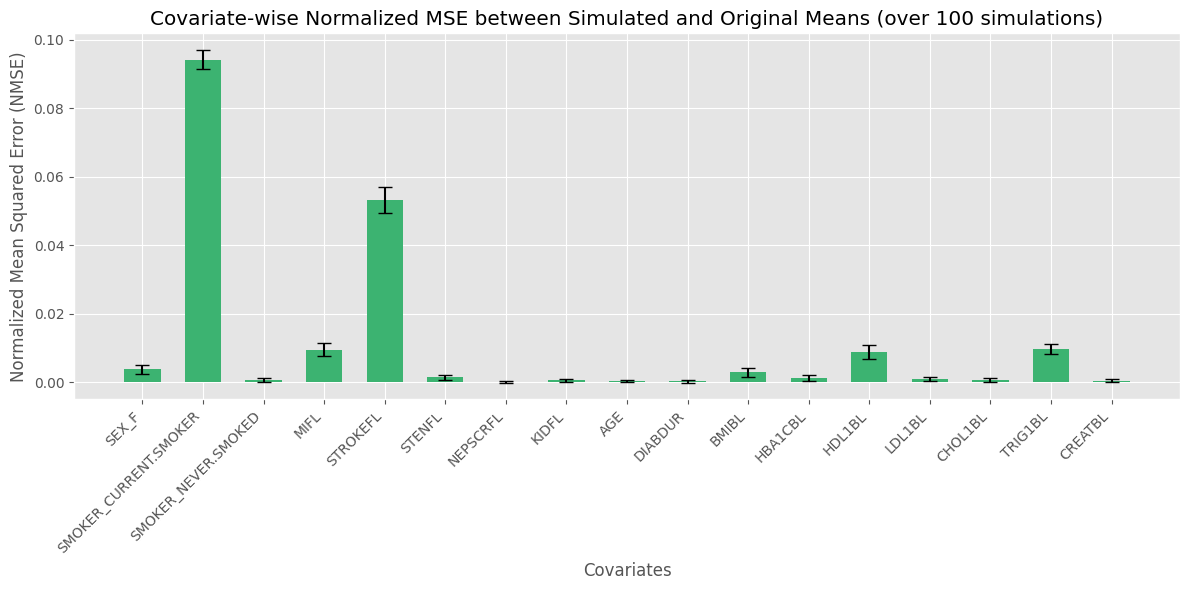

Classification Accuracy: Mean=0.602, Std=0.007, Min=0.581, Max=0.620
Classification AUC: Mean=0.650, Std=0.006, Min=0.637, Max=0.663


In [67]:

# Parameters for simulation loop
num_simulations = 100  # adjust as needed
accuracy_list = []
auc_list = []
# To store squared errors for each covariate in each simulation
covariate_squared_errors = []

# original_df is assumed to be created from df_bsl_features (the original covariate data)
original_df = deepcopy(df_bsl_features)
original_df['source'] = 'Original'
# Compute the means for the original covariates (drop any non-covariate columns if necessary)
orig_cov_means = original_df.drop(columns='source').mean()

# Compute standard deviation for each covariate in the original data
orig_cov_std = original_df.drop(columns='source').std(ddof=1)

# Initialize a list to store normalized squared errors
normalized_covariate_squared_errors = []

for i in range(num_simulations):
    # Sample s_pred (and x if needed)
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Convert simulated s_pred to DataFrame with matching column names
    simulated_df = pd.DataFrame(s_pred.detach().cpu().numpy(), 
                                columns=original_df.drop(columns='source').columns)
    simulated_df['source'] = 'Simulated'
    
    # Combine original and simulated data for classification (if needed)
    combined_df = pd.concat([original_df, simulated_df], ignore_index=True)
    X = combined_df.drop(columns='source')
    y = combined_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split data and train logistic regression as before...
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        random_state=42, stratify=y)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))
    
    # Compute the squared error between simulated and original means for each covariate
    sim_cov_means = simulated_df.drop(columns='source').mean()
    # Normalize squared error by dividing by variance (i.e., std^2)
    normalized_error = ((sim_cov_means - orig_cov_means) / orig_cov_std) ** 2
    normalized_covariate_squared_errors.append(normalized_error)

# Convert the list of normalized squared errors into a DataFrame for analysis
norm_cov_err_df = pd.DataFrame(normalized_covariate_squared_errors)

# Compute mean and std of normalized errors for each covariate
norm_mse_mean_cov = norm_cov_err_df.mean()
norm_mse_std_cov = norm_cov_err_df.std(ddof=1)

# Bar plot for normalized MSE of covariates with error bars
fig, ax = plt.subplots(figsize=(12, 6))
x_positions = np.arange(len(norm_mse_mean_cov))
width = 0.6
ax.bar(x_positions, norm_mse_mean_cov, yerr=norm_mse_std_cov, capsize=5, width=width, color='mediumseagreen')
ax.set_xticks(x_positions)
ax.set_xticklabels(norm_mse_mean_cov.index, rotation=45, ha='right')
ax.set_xlabel('Covariates')
ax.set_ylabel('Normalized Mean Squared Error (NMSE)')
ax.set_title('Covariate-wise Normalized MSE between Simulated and Original Means (over {} simulations)'.format(num_simulations))
plt.tight_layout()
plt.show()

# Print summary statistics for classification performance over simulations
print("Classification Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("Classification AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


In [68]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --- Preprocessing the True (Original) Joint Data ---
# Assume that missing_impute is defined and the original tensors (x_tensor, z_tensor, y_tensor, s_tensor) exist.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Convert the true tensors to numpy arrays (s_true_np is used as part of the joint features)
s_true_np = s_tensor.detach().cpu().numpy()
z_true_np = z_tensor.detach().cpu().numpy()
y_true_np = y_tensor.detach().cpu().numpy()

# Create a DataFrame for the original joint data
original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z_true_np, y_true_np], axis=1),
    columns=[f's_{i}' for i in range(s_true_np.shape[1])] +
            [f'z_{i}' for i in range(z_true_np.shape[1])] +
            [f'y_{i}' for i in range(y_true_np.shape[1])]
)
original_joint_df['source'] = 'Original'

# --- Simulation Loop ---
num_simulations = 100  # adjust as needed
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample a new s_pred (and x_sim if needed) from the baseline model
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Get joint predictions from your main model using the sampled s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing data imputation to the predictions
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert predicted tensors to numpy arrays
    s_pred_np = s_pred.detach().cpu().numpy()
    z_pred_np = z_pred.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()
    
    # Create a DataFrame for the simulated joint data
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z_pred_np, y_pred_np], axis=1),
        columns=[f's_{i}' for i in range(s_pred_np.shape[1])] +
                [f'z_{i}' for i in range(z_pred_np.shape[1])] +
                [f'y_{i}' for i in range(y_pred_np.shape[1])]
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train a logistic regression classifier on the joint data
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_joint_pred = clf_joint.predict(X_test)
    y_joint_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC for the simulation iteration
    accuracy_joint = accuracy_score(y_test, y_joint_pred)
    auc_joint = roc_auc_score(y_test, y_joint_pred_proba)
    
    # Store the results
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (over {} simulations):".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (over 100 simulations):
Accuracy: Mean=0.658, Std=0.005, Min=0.643, Max=0.669
AUC: Mean=0.694, Std=0.004, Min=0.685, Max=0.706


In [62]:
original_joint_df.columns

Index(['s_0', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9',
       's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 'z_0', 'z_1',
       'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'z_10', 'z_11',
       'z_12', 'z_13', 'z_14', 'z_15', 'z_16', 'z_17', 'z_18', 'z_19', 'z_20',
       'z_21', 'z_22', 'z_23', 'z_24', 'z_25', 'z_26', 'z_27', 'z_28', 'z_29',
       'z_30', 'z_31', 'z_32', 'y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6',
       'y_7', 'y_8', 'y_9', 'y_10', 'source'],
      dtype='object')

In [69]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --- Preprocessing the True (Original) Joint Data using s, z1, and y ---
# Assume missing_impute is defined and the original tensors exist.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Define parameters for reshaping z
n_obs = z_tensor.shape[0]
timepoints = 11
z_dim = 3

# Convert s and y tensors to numpy arrays
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, y_dim)

# Process z: reshape and extract z1 (first dimension over time)
z_true_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)   # shape: (n_obs, timepoints, z_dim)
z1_true_np = z_true_reshaped[:, :, 0].detach().cpu().numpy()     # shape: (n_obs, timepoints)

# Create a DataFrame for the original joint data using s, z1, and y
# Name columns for s, z1 (across timepoints), and y
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_time_{t}' for t in range(timepoints)]
y_cols = [f'y_{i}' for i in range(y_true_np.shape[1])]

original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true_np, y_true_np], axis=1),
    columns = s_cols + z1_cols + y_cols
)
original_joint_df['source'] = 'Original'

# --- Simulation Loop ---
num_simulations = 100  # adjust as needed
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample a new s_pred from the baseline model
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Get joint predictions from your main model using the sampled s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing data imputation to the predictions
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert predicted s and y tensors to numpy arrays
    s_pred_np = s_pred.detach().cpu().numpy()    # shape: (n_obs, s_dim)
    y_pred_np = y_pred.detach().cpu().numpy()      # shape: (n_obs, y_dim)
    
    # Process predicted z: reshape and extract z1
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)  # shape: (n_obs, timepoints, z_dim)
    z1_pred_np = z_pred_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)
    
    # Create a DataFrame for the simulated joint data (using s, z1, and y)
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred_np, y_pred_np], axis=1),
        columns = s_cols + z1_cols + y_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train a logistic regression classifier on the joint data (s, z1, and y)
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_class = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC for this simulation iteration
    accuracy_joint = accuracy_score(y_test, y_pred_class)
    auc_joint = roc_auc_score(y_test, y_pred_proba)
    
    # Store the results
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (s, z1, and y) over {} simulations:".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (s, z1, and y) over 100 simulations:
Accuracy: Mean=0.650, Std=0.005, Min=0.633, Max=0.661
AUC: Mean=0.683, Std=0.004, Min=0.672, Max=0.694


In [70]:
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# --- Preprocessing the True (Original) Joint Data using s, z1, and y ---
# Assume missing_impute is defined and the original tensors exist.
x_tensor, z_tensor, y_tensor = missing_impute(x=x_tensor, z=z_tensor, y=y_tensor, x_dim=1, z_dim=3)

# Define parameters for reshaping z
n_obs = z_tensor.shape[0]
timepoints = 11
z_dim = 3

# Convert s and y tensors to numpy arrays
s_true_np = s_tensor.detach().cpu().numpy()   # shape: (n_obs, s_dim)
y_true_np = y_tensor.detach().cpu().numpy()     # shape: (n_obs, y_dim)

# Process z: reshape and extract z1 (first dimension over time)
z_true_reshaped = z_tensor.reshape(n_obs, timepoints, z_dim)   # shape: (n_obs, timepoints, z_dim)
z1_true_np = z_true_reshaped[:, :, 0].detach().cpu().numpy()     # shape: (n_obs, timepoints)

# Create a DataFrame for the original joint data using s, z1, and y
# Name columns for s, z1 (across timepoints), and y
s_cols = [f's_{i}' for i in range(s_true_np.shape[1])]
z1_cols = [f'z1_time_{t}' for t in range(timepoints)]
y_cols = [f'y_{i}' for i in range(y_true_np.shape[1])]

original_joint_df = pd.DataFrame(
    np.concatenate([s_true_np, z1_true_np, y_true_np], axis=1),
    columns = s_cols + z1_cols + y_cols
)
original_joint_df['source'] = 'Original'

# --- Simulation Loop ---
num_simulations = 100  # adjust as needed
accuracy_list = []
auc_list = []

for i in range(num_simulations):
    # Sample a new s_pred from the baseline model
    x_sim, s_pred = model_bsl.sample_xz(sample_size=s_tensor.shape[0])
    
    # Get joint predictions from your main model using the sampled s_pred
    x_pred, z_pred, y_pred = model.sample_joint(s=s_pred)
    
    # Apply missing data imputation to the predictions
    x_pred, z_pred, y_pred = missing_impute(x=x_pred, z=z_pred, y=y_pred, x_dim=1, z_dim=3)
    
    # Convert predicted s and y tensors to numpy arrays
    s_pred_np = s_pred.detach().cpu().numpy()    # shape: (n_obs, s_dim)
    y_pred_np = y_pred.detach().cpu().numpy()      # shape: (n_obs, y_dim)
    
    # Process predicted z: reshape and extract z1
    z_pred_reshaped = z_pred.reshape(n_obs, timepoints, z_dim)  # shape: (n_obs, timepoints, z_dim)
    z1_pred_np = z_pred_reshaped[:, :, 0].detach().cpu().numpy()  # shape: (n_obs, timepoints)
    
    # Create a DataFrame for the simulated joint data (using s, z1, and y)
    simulated_joint_df = pd.DataFrame(
        np.concatenate([s_pred_np, z1_pred_np, y_pred_np], axis=1),
        columns = s_cols + z1_cols + y_cols
    )
    simulated_joint_df['source'] = 'Simulated'
    
    # Combine the original and simulated joint data
    combined_joint_df = pd.concat([original_joint_df, simulated_joint_df], ignore_index=True)
    X_joint = combined_joint_df.drop(columns='source')
    y_joint = combined_joint_df['source'].map({'Original': 0, 'Simulated': 1})
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_joint, y_joint, test_size=0.3, random_state=2025, stratify=y_joint
    )
    
    # Train a logistic regression classifier on the joint data (s, z1, and y)
    clf_joint = LogisticRegression(max_iter=1000)
    clf_joint.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_class = clf_joint.predict(X_test)
    y_pred_proba = clf_joint.predict_proba(X_test)[:, 1]
    
    # Compute accuracy and AUC for this simulation iteration
    accuracy_joint = accuracy_score(y_test, y_pred_class)
    auc_joint = roc_auc_score(y_test, y_pred_proba)
    
    # Store the results
    accuracy_list.append(accuracy_joint)
    auc_list.append(auc_joint)

# --- Print Summary Statistics ---
print("Joint Data Classification Results (s, z1, and y) over {} simulations:".format(num_simulations))
print("Accuracy: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(accuracy_list), np.std(accuracy_list, ddof=1), np.min(accuracy_list), np.max(accuracy_list)))
print("AUC: Mean={:.3f}, Std={:.3f}, Min={:.3f}, Max={:.3f}".format(
    np.mean(auc_list), np.std(auc_list, ddof=1), np.min(auc_list), np.max(auc_list)))


Joint Data Classification Results (s, z1, and y) over 100 simulations:
Accuracy: Mean=0.649, Std=0.005, Min=0.636, Max=0.661
AUC: Mean=0.682, Std=0.004, Min=0.662, Max=0.690
